# **How to Drive a Car with a Camera [Part 2 - Carnegie Mellon & Alvinn]**


 [jupytertheme](https://github.com/dunovank/jupyter-themes) for this talk: 

```
jt -t grade3 -cellw=90% -fs=20 -tfs=2- -ofs=20
```

- Originally, the ALV was intended to a "test bed" vehicle for universities. However, due to rigorous demo schedules and other factors, it was difficult for researchers to get time on the ALV.
- CMU requested $1.2M of DARPA funds to build two of thier own vehicles, and by early 1986 had purchased and outfitted a chevy van, and gave it the name Navlab (NAVigation LABratory)
- Max speed of 20 mph! (Suck it, ALV) Early demos ran at 10 centimeters per second.


![](../graphics/navlab.png)

- Many approaches were tried at CMU, let's talk about one particularly interesting approach taken by graduate student **Dean Pomerleau**
- To really get a feel for his approach, let's think about the problem we're trying to solve more broadly
- We're trying to **drive a car with a camera**, and here's a diagram of the approach we've tried so far:

![](../graphics/alv_pipeline-01.png)

- There are lots of ways we can break apart the driving problem into discrete blocks to engineer solutions, but broadly, if our car is going to steer (or fully drive itself), we must solve this problem:

![](../graphics/spacer_small-01.png)

![](../graphics/end-to-end-math-problem-01.png)

- If you want to drive a car with a camera, you must find an answer to this math problem
- One way to think about vision-based autonomous driving then is as a mapping from a very high dimensional space (one or more images), to a very low dimensional space (just steering angle, or in the case of lateral and longitudinal control, steering angle and speed)
- But, how do we go apart solving a math problem like this? We found one sub-optimal solution by studying the ALV, how else might we approach this problem?
- Here's a hint: when Dean Pomerleau showed up at CMU for graduate school in 1987, an associate professor name Geoff Hinton had just published a report entitled "Experiments on Learning by Back Propagation."
- This lead Pomerleau down an intersting path: 

# What if we used a neural network to learn, like, the whole thing?

![](../graphics/spacer_small-01.png)

- Is it possible to train a nueral network to learn **all the math** to steer a car?
    - [FUN FACT] when I began working in autonomous driving in June 2016 I had exactly this conversation with a long-time friend and coworker, and I argued this this might not even be possible. Let's see if I was right...

# Can we teach a neural network to drive?

![](../videos/images_and_angle_wheego.gif)

- Or at least, to steer?
- Can we learn the mathematics of this (or one version of this) mapping?
- The forward direction of this problem makes reasonable sense, but to train a neural network, we must find an appoximate solution to the **inverse** problem!
    - Does steering wheel angle alone provide enough information to teach a learning algorithm how to interpret images of the road??

- Here's Pomerleau's original NIPS paper: **ALVINN: An Autonomous Land Vehicle In a Neural Network**

![](../graphics/pomerleau-nips.png)

![](../graphics/spacer_small-01.png)

- Here's the nueral network architecture used by Dean Pomerleau
- Pomerleau (at least initially) just used the blue image channel, and downsampled his images to just (30x32) pixels.
- The output of ALVINN is setup cleverly - steering angles are grouped into 30 discrete bins, and training data is setups as a guasian distribution around the the bin corresnponding to the current steering angle - this makes the problem more linear - small changes in input images correspond to small changes in output values.

![](../graphics/question-two-01.png)

![](../graphics/spacer_small-01.png)

In [1]:
30*32*4+30*4 #Plus bias units - but let's be honest, who really cares about counting those?

3960

- ~4k parameters
    - This is either a lot or like nothing depending on your perspective
    - Out last approach, the ALV VITS algorithm had 4 parameters
    
    - VGG-16, a modern popular deep neural network has 138M parameters!
- Now, if we're going to learning a mapping from images to steering wheel angles (that will hopefully drive a car!) we need some data.
    - One very cool thing about Pomerleau's idea here is that collecting data is easy!
    - Just put a camera and steering wheel angle sensor on a car, and record how a human drives!
        - This technique is called **behavioral cloning**, and it's an amazingly simple way to get lots and lots of data.

## **Data!**

- I've prepared a small dataset for us to play with
- Taken on a few test track laps


In [2]:
from jupyterthemes import jtplot
jtplot.style()

In [3]:
import h5py as h5
%pylab inline
data = h5.File('../data_sample/track_data_2.h5', 'r')

Populating the interactive namespace from numpy and matplotlib


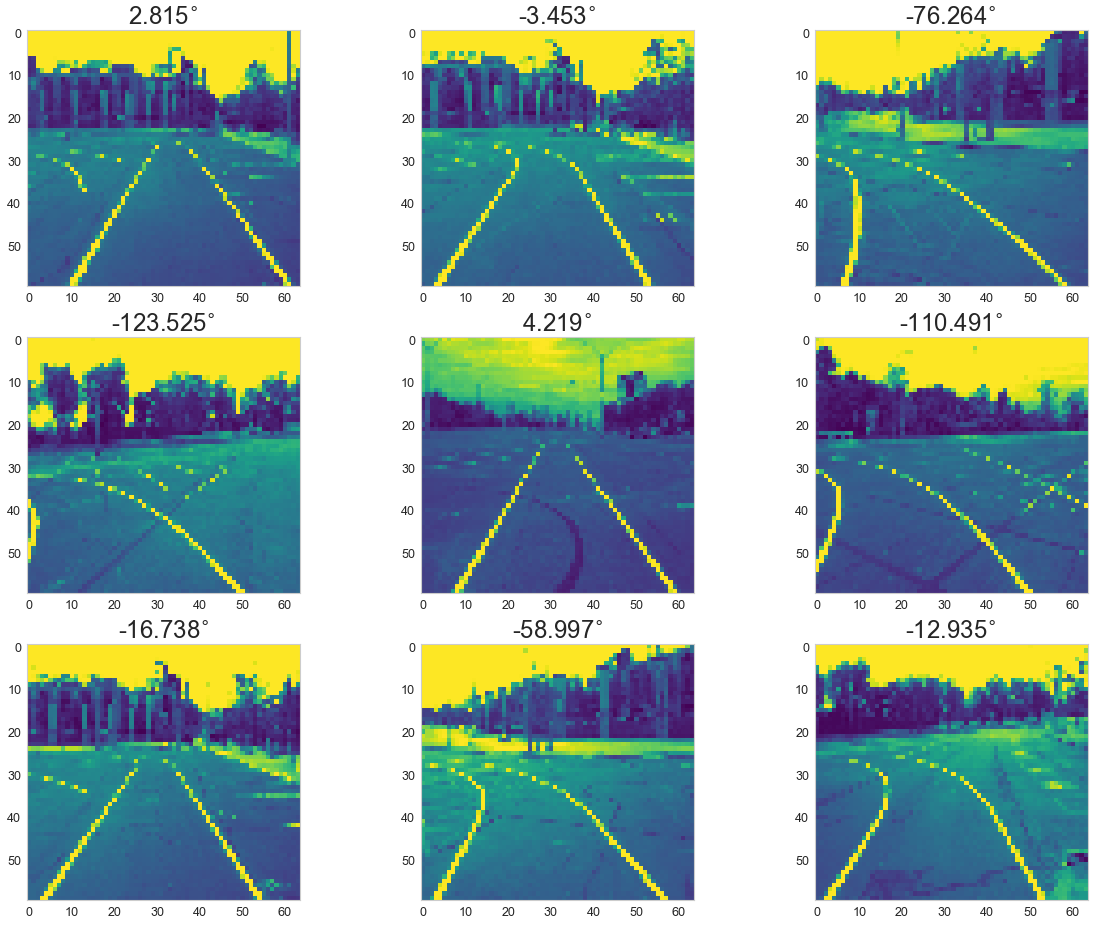

In [4]:
fig = figure(0, (20, 16))
for i in range(9):
    fig.add_subplot(3, 3, i+1)
    imshow(data['images'][i*100, :, :]); grid(0)
    title(str(round(data['angles'][i*100], 3)) + '$^{\circ}$', fontsize = 24)

- Our data consists of the blue channels of resized images, and the corresponding steering angles.

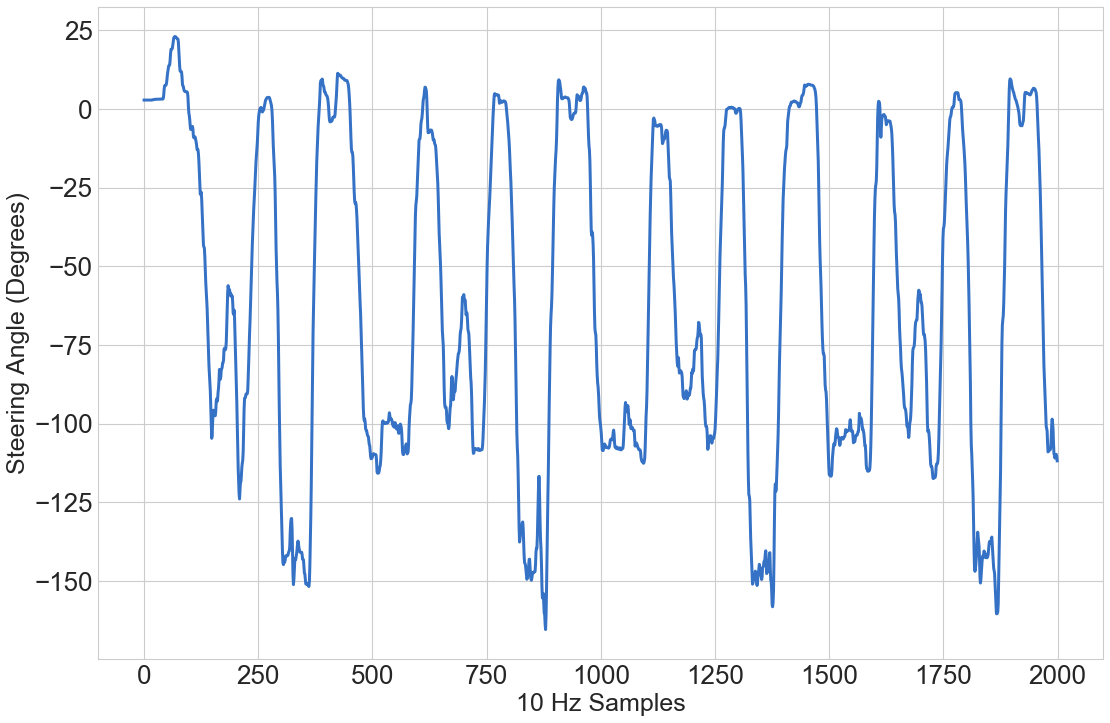

In [5]:
fig = figure(0, (18, 12))
plot(data['angles'], linewidth = 3)
ylabel('Steering Angle (Degrees)', fontsize = 25); xlabel('10 Hz Samples', fontsize = 25)
for tick in gca().xaxis.get_major_ticks():
    tick.label.set_fontsize(26) 
for tick in gca().yaxis.get_major_ticks():
    tick.label.set_fontsize(26) 

- Here's all the steering angles in our dataset sequentially. 
- Our data roughly has a periodicity of 3 - why?

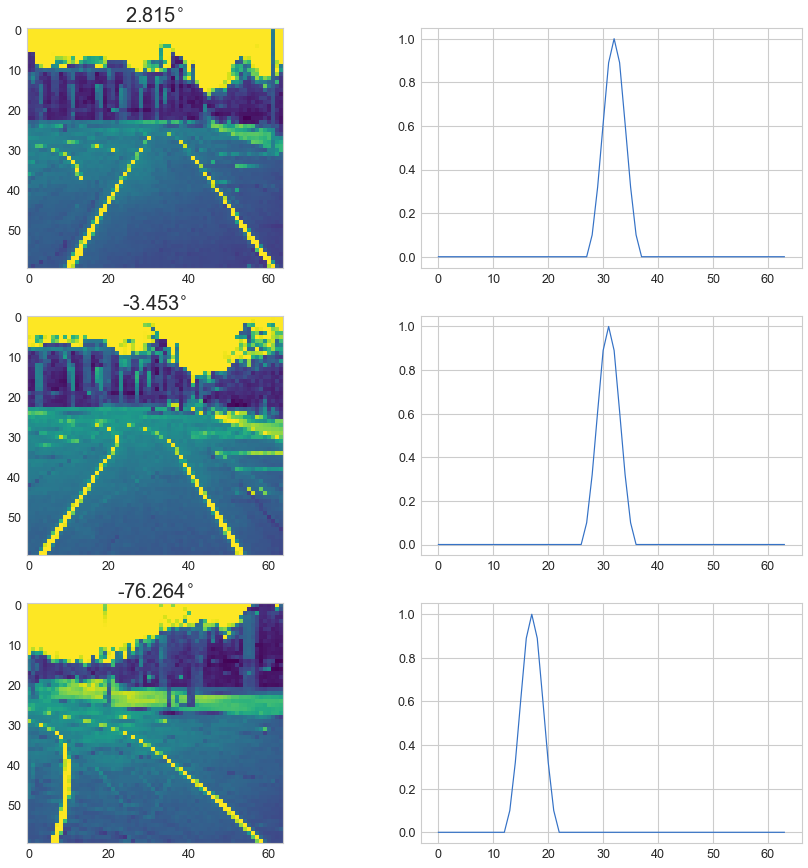

In [6]:
fig = figure(0, (15,15))
for i in range(3):
    fig.add_subplot(3,2,2*i+1)
    imshow(data['images'][i*100, :, :]); grid(0)
    title(str(round(data['angles'][i*100], 3)) + '$^{\circ}$', fontsize = 20)    
    
    fig.add_subplot(3,2,2*i+2)
    plot(data['encoded_angles'][i*100, :])

- Finally, I've also gone ahead and encoded our steering angles as pomerleau did.
- This really makes a big difference! 
    - Little tweaks and changes can make all the difference when optimizing the complex non-convex loss function we often find in neural networks. 
- Representing the correct steering angle as a distribution be make the difference between our network being able to learn or not!

### And finally, the most important part of any machine learning solution....
- Test train split!

In [7]:

training_indices = np.arange(1500)
testing_indices = np.arange(1500, 2000)

images_training = data['images'][training_indices, :, :]/255. #Normalize between 0 and 1
angles_training = data['encoded_angles'][training_indices, :]

images_testing = data['images'][testing_indices, :, :]/255. #Normalize between 0 and 1
angles_testing = data['encoded_angles'][testing_indices, :]


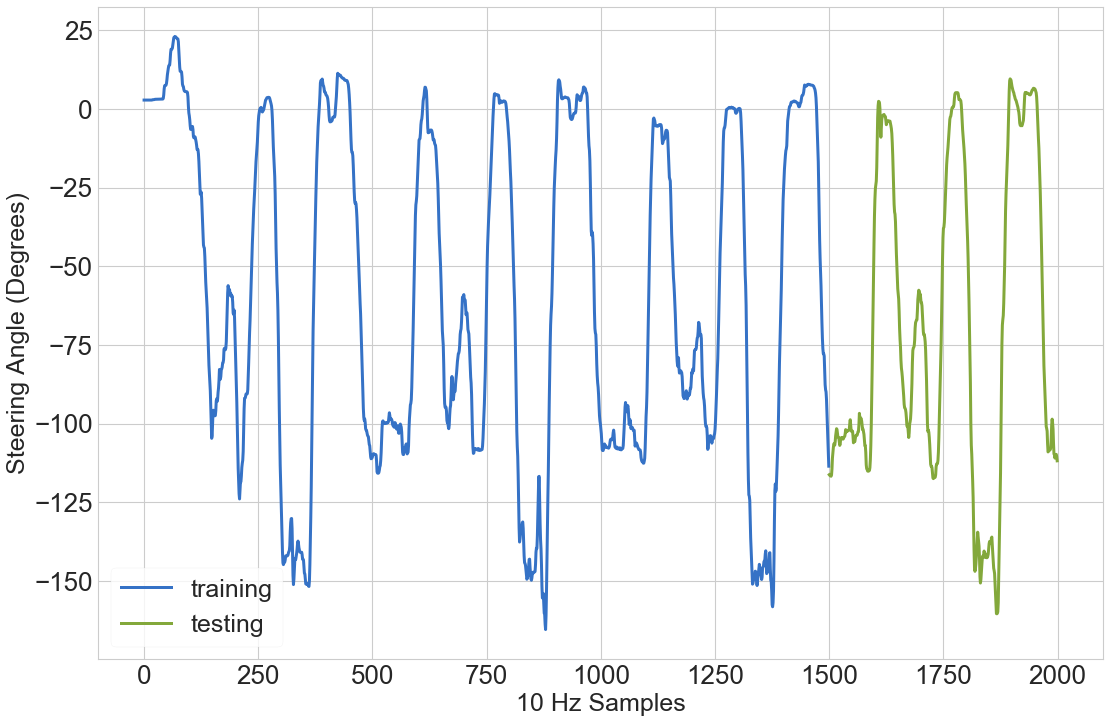

In [8]:
fig = figure(0, (18, 12))
plot(training_indices, data['angles'][:][training_indices], linewidth = 3)
plot(testing_indices, data['angles'][:][testing_indices], linewidth = 3)
ylabel('Steering Angle (Degrees)', fontsize = 25); xlabel('10 Hz Samples', fontsize = 25)
for tick in gca().xaxis.get_major_ticks():
    tick.label.set_fontsize(26) 
for tick in gca().yaxis.get_major_ticks():
    tick.label.set_fontsize(26) 
legend(['training', 'testing'], fontsize = 25)


- We'll use ~3 laps (1500) images for training, and 1 lap (500) images for testing

# Ok, Let's build ALVINN in Tensorflow!

- Let me go ahead and start training, then we'll talk through the architecture

In [9]:
import tensorflow as tf

In [10]:
#Hyper Parameters
learning_rate = 1e-4
num_iterations = 5000

#How many bins is our data encoded into:
bins = angles_training.shape[1]

#Setup tf placeholders for images and angles
im = tf.placeholder(tf.float32, (None, 60, 64))
ang = tf.placeholder(tf.float32, (None, bins))

#Reshape input images into vectors
im_reshaped = tf.reshape(im, (-1, 60*64))

#Hidden Layer
a1 = tf.layers.dense(im_reshaped, 4, activation = tf.sigmoid)

#Output layer
yhat = tf.layers.dense(a1, bins)

#Loss function
loss = tf.losses.mean_squared_error(ang, yhat)

#Optimizer
train_op = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(loss)

AttributeError: module 'tensorflow' has no attribute 'placeholder'

- The fact that we can define the entire architecture of ALVINN in 5 lines of tensorflow is unreal.
- We'll make a few minor changes to the oringal network. 
    - 9 hidden units instead of 4
    - (64x60) images instead of (32x30)
    - 64 output bins instead of 32
    - That's it! Other than that this is the ALVINN network from the 1980s!

In [ ]:
from IPython import display

#Store errors as we train in a list:
RMSEs = []

#Initialize Tensorflow session:
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

#And train!
for i in range(num_iterations):
    #Train Step
    sess.run(train_op, feed_dict = {im:(images_training), ang:angles_training})
    #Measure error
    RMSEs.append(np.sqrt(loss.eval(feed_dict = {im:images_training, ang:angles_training})))

    #Visualize as we go!
    if i%25==0:
        clf(); fig = figure(0, (18, 9))
        plot(RMSEs, linewidth = 2)
        xlabel('Iterations'); ylabel('RMSE')
        display.clear_output(wait=True); display.display(gcf())

In [ ]:
#Network Predictions on Testing Images:
yhat_array = yhat.eval(feed_dict = {im:images_testing})

#Center values of our prediction bins:
centers = np.linspace(-165, 165, bins)

# Convert probabilistic prediction to a single angle
predicted_angles = []
for i in range(yhat_array.shape[0]):
    #Just pick bin with largest value:
    predicted_angles.append(centers[argmax(yhat_array[i, :])])
    
    #Could use a fancy weighted average instead:
    #predicted_angles.append(sum(centers[yhat_array[i, :] > 0.3]*yhat_array[i, \
    #                    yhat_array[i, :] > 0.3])/sum(yhat_array[i, yhat_array[i, :] > 0.3]))

In [ ]:
fig = figure(0, (16, 10))
plot(data['angles'][:][testing_indices], linewidth = 3)
plot(predicted_angles, linewidth = 3)
ylabel('Steering Angle (Degrees)', fontsize = 25);
title('Test Set RMSE = ' + str(round(np.sqrt(np.mean((predicted_angles- data['angles'][:][testing_indices])**2)), 3)) + ' degrees.')
legend(['$y$', '$\hat{y}$'], fontsize = 25)
for tick in gca().yaxis.get_major_ticks():
    tick.label.set_fontsize(26)
    

## Our ALVINN learned!
- From 3 laps of test track driving data, ALVINN learned to predict quite close to the correct steering angle on our 4th lap!
- Just using camera images and our human steering angle, ALVINN learned to drive (somewhat) like a human!
- Pretty cool, right?!
- I think it's soo remarkable that the (relatively sparse) information source of just the steering angle is enough to teach our network to pick out salient image features!
- Let's explore this a little more deeply.

# Now, what the heck did our network learn to "see"?

- What mathematical mapping from images to steering angle did our algorithm learn?
- Let's have a closer look at ALVINN's parameters during training.

![](../videos/training_animation_smaller.gif)

### <center> *"...in this paradigm the data, not the programmer, determines the salient image features crucial to accurate road navigation" * </center>

<div style="text-align: right">- Dean Pomerleau in ALVINN: An Autonomous Land Vehicle in a Neural Network </div>

- Our network has learned to intrepret driving images based ONLY on steering angle! 
- For this data (track data with only left turns), our network has learned a set of lane marker detectors!


## **ALVINN Domination**

- For a number of years from the late 1980s to the early 1990s, ALVINN was the most successfull vision algorithm for autonomous driving at CMU, and possibly on the planet.
- Faster computers enabled faster driving, and more sophisiticed training and data augmentation procedures allowed ALVINN to learn quickly and effectively across many environments.

![](../videos/NAVLAB_B.gif)

- And quite recently, Nvidia implemented Pomerleau's idea using **Deep Neural Networks**
- Great writeup in thier publication [End to end learning for self-driving cars](https://images.nvidia.com/content/tegra/automotive/images/2016/solutions/pdf/end-to-end-dl-using-px.pdf)
- Pomerleau orinally trained on ~5 minutes of driving, Nvidia trained on 3000 hours
    - That's 36,000 times the amount of data - **5 orders of magnitude** increase in dataset size in 30 years. 


![](papers/nvidia.png)

Here's the Architecture Nvidia used:

![](../graphics/nvidia-architecture-01.png)

- ~125k parameters
- So we've gone from 4 parameters in the ALV algorithm to 4k parameters in ALVINN to 125k pameters in Nvidia's end-to-end deep learning algorithm!
- And here's Nvidia's network driving in lots of different environments:

![](../videos/Nvidia_short.gif)

# Ok, so time for production, right?

- Here's where it gets interesting. Many folks in the Autonomous Driving industry do not believe we will ever see an end-to-end systems in production. 
- And further, we didn't quite finish our story from earlier, about the 98% autonomous "No Hand Across America" Navlab 5 journey in 1995 - intrestingly Pomerleau didn't use ALVINN!
    

# So, **why not?** 
- Why do you think end-to-end systems like ALVINN may not be part of future autonomous cars?
- What are the potential weaknesses of this approach? Thoughts?

![](../graphics/spacer_small-01.png)

- Let's see if we can shed some light on this problem by considering the appraoches we've implemented thusfar:

![](../graphics/analytical_emprical_spectrum-01.png)

- One way to think about the two systems we've talked about so far is as two end of a spectrum
- There's a very interesting dynamic/tension between analytical and empircal (data based) problem solving, and we're seeing it played out here beautifully in autonomous driving!
- **Purely analytical or purely empirically solutions will probably never drive a car everywhere safely**
     - The good solutions are probably in the middle of the spectrum
- Things get really interesting when we consider blends of these appraoches
- Interestingly, there's some evidence that science and engineering interest in analytical/emprical problem solving is cyclical. Right now we may be in an "empirical peak"!

![](../graphics/spacer_small-01.png)

![](graphics/spacer_small-01.png)

# **Some Good Solutions**

- Let's look at two interesting approaches. 
- First, how *did* Dean Pomerleau drive 98% of the way across the US in 1995?!?!

![](../graphics/no-hands-summary-images-01.png)

- Suprisingly (to me at least), it wasn't ALVINN that completed the "No Hands Across America" drive in 1995.
    - According to Dean, "ALVINN could have driven across America, but would have required frequent retraining, each of each would have required a few minutes of watching a human drive."
    - ALVINN had to be retrained on human data in each new environment.
- So, how then did Pomerleau and Jochem make it across the US just a few years later 98% autonomously?
- This brings us to a fun story...

## **One snowy evening in Colorado**

- Dean Pomerleau and CMU Professor Charles Thorpe were driving back from a DARPA meeting in colorado, when Dean asked himself an interesting question:

# How is it that a human can navigate a scene like this?

![](../videos/snow_2.gif)

- Imagine trying to solve this problem with ALV color-based segementation approach we started with!
- So, how do *you* (as a human, presumetively) know where to drive on a road like this?

## Pomerleau's Insight

*"I realized it was the consistent appearance of these fuzzy features as they stretched into the distance ahead of the car that was allowing me to steer the vehicle, not any single, invariant feature like a lane marker at a particular location. **It hit me that this consistency could be captured and represented one-dimensionally by "unwrapping" the road curvature and them projecting downward onto a line. By trying various "unwrappings" and seeing which one resulted in a linear representation with the strongest peaks and valleys, an algorithm could capture and reason about whatever regularities there were in the appearance of the road ahead, without caring about what those features actually represent.** The idea for the RALPH algorithm was born. It worked for snow, but more importantly, it also worked for the subtle discoloration you often find in the pavement, e.g. the darkness in the center of the lane due to oil drops from previous vehicle. Being able to leverage subtle features like this make RALPH much more robust in the face of faint or occluded traditional features, like lane markings."*

<div style="text-align: right">- Dean Pomerleau</div>



Here's how RALPH (Rapidly Adapting Lateral Position Handler) worked:

![](../videos/ralph_1.gif)

- First, a trapezoidal region on the ground plane in front of the car was sample. 
    - Although trapeziodal in image space, this is actually close to a square in world space.
    - This sampling area was programmed to move further out in front of the car as speed increased.
- Next, the trapezoidal area was resampled into a (32x30) image
    - This iamge looks like a bird's eye view of the road
- The following step is cool: based on information from previous images, RALPH makes some educated guesses about road curvature
    - These cuvatures are used to "unwrap" the image as shown above - the central idea here being that the right unrapping will result in linear features!
    - For each unwrapping, the pixels values are summed vertically, resulting in a one dimensional "scanline intensity profile"
    - The intuition here is that properly unwrapped linear reprentations of the road will be projected down into intensity profiles with strong peaks and valleys, corresponding to whatever features are visually important in the image. 
- Linear scan profiles are scored with a simple heuristic algorithm. 
    - The difference of adjacent values is computed, and the sum of the absolute value of the 5 larges differences is used as a score
- The unrapping with the largest score is used to estimate road curvature.
- One reason this idea works well is that it's capable of "locking" on to any feature that follows the curve of the road and is consistent as we move forward in the image.
    - Notice that our scaline intensity profile has picked up on our lane markers, which makes sense - but also the dark region in the center of the lane!  

## But is the curvature of the road enough information to like..drive the car?


- Nope! There's one more important step. 
- Up until this point, RALPH has been pretty much analytical. Here's where we see an interesting blend of analytical and empirical methods!
- Road curvature is not enough information to drive a car, but if we know just one more thing, we can actually do a pretty great job. 
    - The missing piece here is the **lateral offset** of the vehicle in the lane. 
- How can we determine how centered our vehicle is?
    - After all, the features we've picked out here are arbitrary - we don't know if they correspond to lane markers, raod discolorations, track in the snow, and we really don't want to have to make any assumptions about what our "guiding" features are.
        - Sounds like a job for an empirical approach!
        
    

![](../videos/ralph_in_action.gif)

- RALPH determines it's offset in the lane by comparing it's current scanline intensity profile (after finding curvature) with a reference intensity profile.
    - Just slide the current profile over the reference profile and look for the highest correlation!
- The reference profile can be learned from watching a human drive (hopefully in the center of the lane!), and importantly, and be adapted **on the fly**, unlike ALVINN.
- RALPH is interesting becuase it combines some strengths of our empirical and analytical approaches.
- RALPH incorperates more human knowledge than ALVINN, without making too many limiting assumptions. 
- Dean puts it this way:

*"RALPH had the built-in heuristic that ALVINN lacked (and therefore had to learn) - namely **"whatever the features that were going to be useful for locating the position and curvature of the road ahead, they would be consistent in appearance as you walk forward in the image".** So RALPH enjoyed the flexibility of a machine learning system, but with some built-in knowledge tailored to the task of lane tracking that made it more efficient and more robust relative to the tabula rasa NN learning approach in ALVINN."*



# And that's how Navlab 5 drove almost all the way across the country autonomously in 1995

![](../graphics/spacer_small-01.png)

In case you're interested, here's Ralph in the snow:

![](../videos/ralph_in_snow.gif)

![](../graphics/spacer_small-01.png)

# And Finally, Let's Talk About Tesla

![](../videos/tesla_2.gif)

- Here we are 20 years later, and Tesla autopilot is a great example of computer vision for autonomous driving
- Clearly using a blend of empirical and analytic techniques
- We can see here they are most likely using some type of deep learning appraoches for object and sign detection
    - And probably for lane marker detection
- In general, deep learning techniques are replacing simpler approaches like RALPH, and companies are generaly using machine learning to create semantically rich "perception layers"
    - The outputs of these perception layers - lane markers, vehicles, objects, are then generally used as inputs to some type of path planning
- Looks like the objects have been smoothed in time, perhaps with a Kalman Filter or RNN
- Doesn't look like lane marker detectinos have been smoothed a great deal
- I'm guessing that they're using flow to localize to some type of map, and probably for some other things.
- It seems like maps are going to play a critical role as well, and there's some really interesting overlaps between maps and precpetion - check out a [talk from Mobileye's Amnon Shashua for more](https://www.youtube.com/watch?v=GQ15HWCw_Ic)


![](graphics/spacer_small-01.png)

![](../graphics/spacer_small-01.png)

![](graphics/spacer_small-01.png)

## References

[1] Roland, Alex; Shiman, Philip (2002). Strategic Computing: DARPA and the Quest for Machine Intelligence, 1983-1993. Cambridge, Mass.: MIT Press. ISBN 0-262-18226-2.

[2] "Look Ma, No Driver" Jim Schefter. Popular Science, October 1985. 

[3] [VITS - A Vision System for Autonomous Land Vehicle Navigation](http://www.cs.ucsb.edu/~mturk/Papers/ALV.pdf); Matthew Turk, David Morgenthaler, Keight Gremban, and Martin Marra